In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [34]:
df = pd.read_csv('data/weather_data.csv')

In [35]:
df = pd.DataFrame(df)

In [36]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2023-12-31 00:00,26.9,2.2,225,29.82,0.00,79,42,0.0,1003
1,2023-12-31 01:00,26.7,2.5,240,29.81,0.00,80,32,0.0,1003
2,2023-12-31 02:00,26.6,2.9,255,29.79,0.01,80,77,0.0,1063
3,2023-12-31 03:00,26.4,3.2,233,29.79,0.01,81,87,0.0,1063
4,2023-12-31 04:00,26.3,3.6,218,29.79,0.00,81,36,0.0,1003


In [37]:
df.duplicated().sum()

0

In [38]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [39]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.9,2.2,225,29.82,79,42
1,26.7,2.5,240,29.81,80,32
2,26.6,2.9,255,29.79,80,77
3,26.4,3.2,233,29.79,81,87
4,26.3,3.6,218,29.79,81,36


In [40]:
len(training)

8088

In [41]:
pd.DataFrame(training).head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.9,2.2,225,29.82,79,42
1,26.7,2.5,240,29.81,80,32
2,26.6,2.9,255,29.79,80,77
3,26.4,3.2,233,29.79,81,87
4,26.3,3.6,218,29.79,81,36


In [42]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [43]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(np.array(training), sequence_length, forecast_horizon)

In [69]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [76]:
num_features = X.shape[2]

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(64, return_sequences=True)),
    tf.keras.layers.GRU(64, return_sequences=True),
    tf.keras.layers.LayerNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(48, return_sequences=False)),
    tf.keras.layers.GRU(32, return_sequences=False),
    tf.keras.layers.LayerNormalization(),
    tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    tf.keras.layers.Dense(16, activation='relu', kernel_regularizer=tf.keras.regularizers.L1(0.01)),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.Adam(), loss='mae', metrics=['mean_absolute_error'])

In [77]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ layer_normalization             │ (None, 6, 6)           │            12 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 6, 64)          │        13,824 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 6, 64)          │           128 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_2           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │           102 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 1, 6)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,122 (98.13 KB)

 Trainable params: 25,122 (98.13 KB)

 Non-trainable params: 0 (0.00 B)

In [78]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_mean_absolute_error', factor = 0.5, patience=4, min_lr=1e-6)

In [79]:
class CustomEarlyStopping(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mean_absolute_error'] <= 5.5 and logs['val_mean_absolute_error'] <= 5.9:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [80]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

In [81]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step - loss: 44.7965 - mean_absolute_error: 42.7473 - val_loss: 14.7648 - val_mean_absolute_error: 13.0190
Epoch 2/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 13.3466 - mean_absolute_error: 11.5052 - val_loss: 10.8916 - val_mean_absolute_error: 9.0095
Epoch 3/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 10.3724 - mean_absolute_error: 8.4862 - val_loss: 9.7633 - val_mean_absolute_error: 7.8906
Epoch 4/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.9762 - mean_absolute_error: 7.1173 - val_loss: 8.9981 - val_mean_absolute_error: 7.1832
Epoch 5/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 8.4391 - mean_absolute_error: 6.6362 - val_loss: 8.8190 - val_mean_absolute_error: 7.0552
Epoch 6/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.8441 - mean_absolute_error: 6.0949 - val_loss: 8.2554 - val_mean_absolute_error: 6.5570
Epoch 7/100
404/404 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 7.7803 - mean_absolute_er

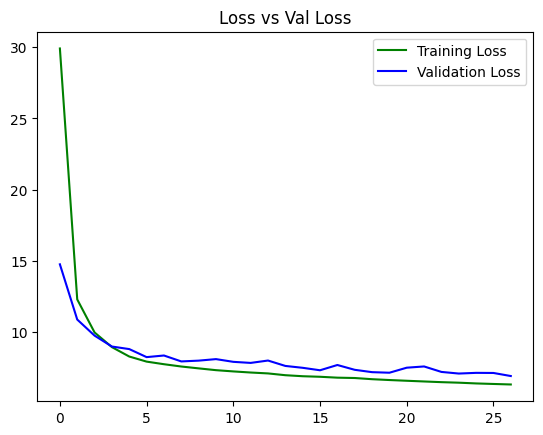

In [82]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

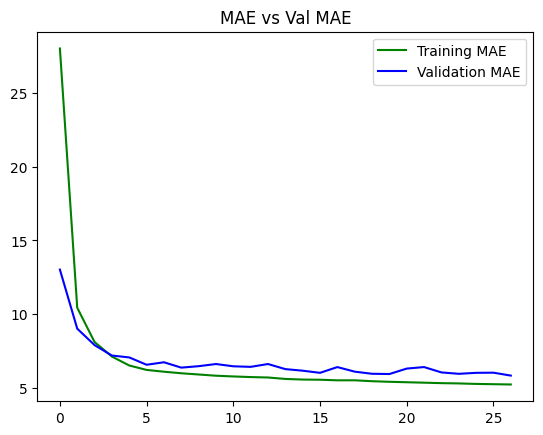

In [83]:
plt.plot(history.history['mean_absolute_error'], color='g', label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [84]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 6.929138660430908, MAE : 5.820986270904541


In [85]:
predictions = model.predict(x_test)

print(predictions[1])
print(y_test[1])

51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
[[29.252853 14.123712 75.707634 29.893587 65.101845 77.318306]]
[[29.4  13.3  58.   29.77 63.   76.  ]]


In [86]:
# model.save("model/forecasting.keras")